# Titan Multimodal Embeddings & Opensearch
## Retail Example -- Indexing and Search
In this notebook we are going to populate the vector database and perform search with text and images. 

We will also do comparisons between different embedding sizes. 

### Define Variables

In [1]:
!pip install -q opensearch-py
!pip install -q requests_aws4auth

In [1]:
import os
import io
import json
import time
import boto3
import base64
import datetime
import pandas as pd
from PIL import Image
import concurrent.futures
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from requests_aws4auth import AWS4Auth
from aoss_utils import createEncryptionPolicy, createNetworkPolicy, createAccessPolicy, createCollection, waitForCollectionCreation
opensearch_client = boto3.client('opensearchserverless')
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

In [2]:
# Define output vector size – 1,024 (default), 384, 256
outputEmbeddingLength = 1024

In [3]:
session = boto3.Session()
identity_arn = session.client('sts').get_caller_identity()['Arn']
print("Current IAM Role ARN:", identity_arn)

Current IAM Role ARN: arn:aws:sts::947565228676:assumed-role/SageMakerRole/SageMaker


### Define dataset

In [4]:
dataset_file = "curated_dataset.json"

### Create embeddings from image

In [5]:
def create_embeddings_from_image(image_path, outputEmbeddingLength):
    max_height = 2048
    max_width = 2048
    
    # Open and resize the image
    with Image.open(image_path) as img:
        if (img.size[0] * img.size[1]) > (max_height * max_width):
            img.thumbnail((max_height, max_width))
            resized_img = img.copy() 
        else:
            resized_img = img 

        # Convert the resized image to bytes
        img_byte_array = io.BytesIO()
        resized_img.save(img_byte_array, format=img.format)
        img_bytes = img_byte_array.getvalue()

    # Encode the resized image to base64
    image_encoded = base64.b64encode(img_bytes).decode('utf8')

    # Prepare the request body
    body = json.dumps(
        {
            "inputImage": image_encoded,
            "embeddingConfig": {
                "outputEmbeddingLength": outputEmbeddingLength
            }
        }
    )

    # Make the API call to the bedrock_runtime
    response = bedrock_runtime.invoke_model(
        body=body,
        modelId="amazon.titan-embed-image-v1",
        accept="application/json",
        contentType="application/json"
    )

    # Parse and return the vector
    vector = json.loads(response['body'].read().decode('utf8'))
    return vector

### Create a vector database using Amazon OpenSearch Serverless

#### Create an Amazon OpenSearch Serverless Collection

In [6]:
client = boto3.client('opensearchserverless')
service = 'aoss'
region = 'us-east-1'
credentials = boto3.Session().get_credentials()
awsauth = AWS4Auth(credentials.access_key, credentials.secret_key, region, service, session_token=credentials.token)
collection_name = "retail-collection-1"

In [7]:
createEncryptionPolicy(client, collection_name)
createNetworkPolicy(client, collection_name)
createAccessPolicy(client, collection_name, identity_arn)
createCollection(client, collection_name)
hostname, collection_id = waitForCollectionCreation(client, collection_name)


Encryption policy created:
{'securityPolicyDetail': {'createdDate': 1712238342926, 'description': 'Encryption policy for retail-collection-1 collections', 'lastModifiedDate': 1712238342926, 'name': 'retail-collection-1-policy', 'policy': {'Rules': [{'Resource': ['collection/retail-collection-1*'], 'ResourceType': 'collection'}], 'AWSOwnedKey': True}, 'policyVersion': 'MTcxMjIzODM0MjkyNl8x', 'type': 'encryption'}, 'ResponseMetadata': {'RequestId': '7ecd5499-1735-4651-845c-3e7105d5bc1a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7ecd5499-1735-4651-845c-3e7105d5bc1a', 'date': 'Thu, 04 Apr 2024 13:45:42 GMT', 'content-type': 'application/x-amz-json-1.0', 'content-length': '369', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}

Network policy created:
{'securityPolicyDetail': {'createdDate': 1712238343025, 'description': 'Network policy for retail-collection-1 collections', 'lastModifiedDate': 1712238343025, 'name': 'retail-collection-1-policy', 'policy': [{'Rules': [{'

#### Create a Collection Index

In [23]:
host = hostname[1]
region = 'us-east-1'
service = 'aoss'
credentials = boto3.Session().get_credentials()
awsauth = AWS4Auth(credentials.access_key, credentials.secret_key, region, service,session_token=credentials.token)

In [24]:
OSSclient = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)

In [25]:
def create_index(index, outputEmbeddingLength) :
    if not OSSclient.indices.exists(index):
        settings = {
            "settings": {
                "index": {
                    "knn": True,
                }
            },
            "mappings": {
                "properties": {
                    "id": {"type": "text"},
                    "name": {"type": "text"},
                    "color": {"type": "text"},
                    "brand": {"type": "text"},
                    "description": {"type": "text"},
                    "createtime": {"type": "text"},
                    "image_path":{"type": "text"},
                    "vector_field": {
                        "type": "knn_vector",
                        "dimension": outputEmbeddingLength,
                    },
                }
            },
        }
        res = OSSclient.indices.create(index, body=settings)
        print(res)

In [26]:
index_name = "retail-dataset-{}".format(outputEmbeddingLength)

In [27]:
create_index(index_name, outputEmbeddingLength)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'retail-dataset-1024'}


### Populate the index

In [28]:
def create_dataset_list(records_file):
    dataset_list = []

    with open(records_file, 'r') as json_file:
            dataset_list = json.load(json_file)
    
    return dataset_list
    
def process_batch(batch, index, outputEmbeddingLength):
    start_time = datetime.datetime.now()
    bulk_data = ""
    for entry in batch:        
        image_location = "images/{}".format(entry["image_path"])
        vector = create_embeddings_from_image(image_location, outputEmbeddingLength)
        dt = datetime.datetime.now().isoformat()
        doc = {
            "vector_field" : vector["embedding"],
            "createtime": dt,
            "id": entry["item_id"],
            "name": entry["item_name"],
            "color": entry["color"],
            "brand": entry["brand"],
            "description": entry["description"],
            "image_path": entry["image_path"]
        }
        
        bulk_entry = "{{\"index\": {{\"_index\": \"{}\"}}}}\n{}\n".format(index, json.dumps(doc))
        bulk_data += bulk_entry
    end_time = datetime.datetime.now()
    processing_time = (end_time - start_time).total_seconds() * 1000  # Convert to milliseconds
    print("Processed {} records in {} ms".format(len(batch), processing_time))
    response = OSSclient.bulk(bulk_data)
    if (response["errors"] is False):
        print("Sent {} records in {} ms".format(len(response["items"]), response["took"]))
    else:
        print("Error found")

def populate_vector_database(records_file, index, outputEmbeddingLength, batch_size=100):
    dataset_list = create_dataset_list(records_file)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Split the dataset into batches
        batches = [dataset_list[i:i+batch_size] for i in range(0, len(dataset_list), batch_size)]

        # Map the process_batch function to each batch in the dataset using multiple threads
        futures = [executor.submit(process_batch, batch, index, outputEmbeddingLength) for batch in batches]

        # Wait for all threads to complete
        concurrent.futures.wait(futures)

In [29]:
populate_vector_database(dataset_file, index_name, outputEmbeddingLength)

Processed 100 records in 67212.751 ms
Processed 100 records in 67918.843 ms
Processed 100 records in 69275.27399999999 ms
Processed 100 records in 69527.33 ms
Processed 100 records in 72636.82699999999 ms
Processed 100 records in 72701.15800000001 ms
Sent 100 records in 2985 ms
Sent 100 records in 3224 ms
Sent 100 records in 4542 ms
Sent 100 records in 5236 ms
Sent 100 records in 1306 ms
Sent 100 records in 1516 ms
Processed 10 records in 4168.17 ms
Sent 10 records in 299 ms
Processed 100 records in 30605.38 ms
Sent 100 records in 657 ms


### Query the vector database

#### Search by text

In [30]:
def get_embedding_for_text(text, outputEmbeddingLength):
    body = json.dumps(
        {"inputText": text, 
         "embeddingConfig": { 
                "outputEmbeddingLength": outputEmbeddingLength
            }
        }
    )

    response = bedrock_runtime.invoke_model(
        body=body, 
        modelId="amazon.titan-embed-image-v1", 
        accept="application/json", 
        contentType="application/json"       
    )

    vector_json = json.loads(response['body'].read().decode('utf8'))

    return vector_json, text

def query_the_database_with_text(text, index, outputEmbeddingLength, k):
    o_vector_json, o_text = get_embedding_for_text(text, outputEmbeddingLength)
    query = {
      'query': {
        'bool': {
            "must": [
                {
                    "knn":{
                       'vector_field':{
                           "vector":o_vector_json["embedding"],
                           "k": k
                       } 
                    }
                }
            ]
        }
      }
    }
    
    response = OSSclient.search(
        body = query,
        index = index
    )
    
    return response
    
def display_images(image_data):
    # Create a subplot with 1 row and the number of images as columns
    num_images = len(image_data)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # Iterate over each image data entry and display the image and description
    for i, entry in enumerate(image_data):
        image_path = "images/{}".format(entry['_source']['image_path'])
        #description = entry['metadata']['description']
        
        # Load and display the image
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title("{}".format(entry['_source']['image_path']))
        axes[i].text(0.5, -0.1, f"Score: {entry['_score']:.4f}", ha='center', transform=axes[i].transAxes)
    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

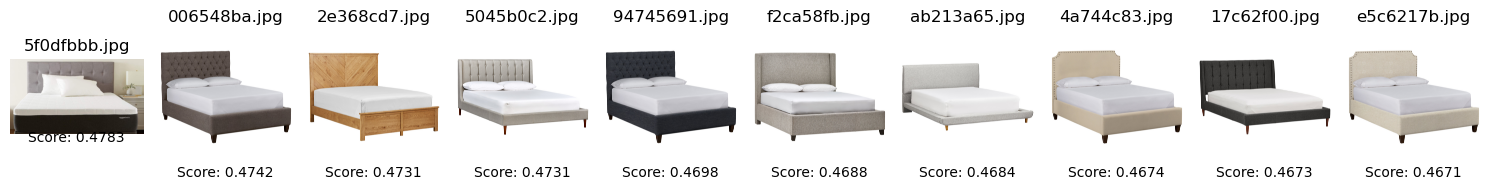

In [43]:
results_text = query_the_database_with_text("A bed", index_name, outputEmbeddingLength, k=10)
# Display the results
display_images(results_text["hits"]["hits"])

#### Search by image

In [33]:
def query_the_database_with_image(image, index, outputEmbeddingLength, k):
    o_vector_json = create_embeddings_from_image(image, outputEmbeddingLength)
    query = {
      'query': {
        'bool': {
            "must": [
                {
                    "knn":{
                       'vector_field':{
                           "vector":o_vector_json["embedding"],
                           "k": k
                       } 
                    }
                }
            ]
        }
      }
    }
    
    response = OSSclient.search(
        body = query,
        index = index
    )
    
    return response

In [47]:
test_image = "test-images/bed.png" # Locate test image

In [48]:
results = query_the_database_with_image(test_image, index_name, outputEmbeddingLength, k=10)

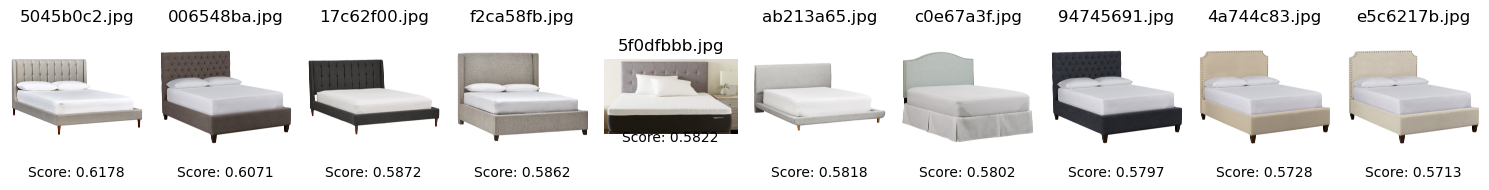

In [49]:
# Display the results
display_images(results["hits"]["hits"])

## Compare different vector sizes results

This section will showcase you the difference between using different vector sizes.

In [50]:
vector_sizes = [1024, 384, 256]
index_name_compare = "retail-dataset"
k = 10

In [51]:
def vector_comparison_populate(vector_sizes, index_name, dataset_file):
    for vector_size in vector_sizes:
        test_index_name = "test-{}-{}".format(index_name, vector_size)
        create_index(test_index_name, vector_size)
        populate_vector_database(dataset_file, test_index_name, vector_size)

def text_query_comparison(vector_sizes, index_name, text_query, k):
    query_results = []
    for vector_size in vector_sizes:
        test_index_name = "test-{}-{}".format(index_name, vector_size)
        query_result = query_the_database_with_text(text_query, test_index_name, vector_size, k)
        query_results.append({
            "index": test_index_name,
            "results": query_result
        })      
    return query_results

def image_query_comparison(vector_sizes, index_name, image, k):
    query_results = []
    for vector_size in vector_sizes:
        test_index_name = "test-{}-{}".format(index_name, vector_size)
        query_result = query_the_database_with_image(image, test_index_name, vector_size, k)
        query_results.append({
            "index": test_index_name,
            "results": query_result
        })      
    return query_results

def print_results(results):
    dfs = []
    for item in results:
        index_name = item['index']
        hits = item['results']['hits']['hits']
    
        df_data = {'title': [], 'score': []}
    
        for hit in hits:
            df_data['title'].append(hit['_source']['name'])
            df_data['score'].append(hit['_score'])
    
        df = pd.DataFrame(df_data)
        dfs.append({index_name: df})
    
    # Concatenate and print dataframes side by side
    dfs_concatenated = pd.concat([list(df_dict.values())[0] for df_dict in dfs],
                                 axis=1,
                                 keys=[list(df_dict.keys())[0] for df_dict in dfs])
    
    return dfs_concatenated


In [52]:
vector_comparison_populate(vector_sizes, index_name_compare,  dataset_file)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'test-retail-dataset-1024'}
Processed 100 records in 60906.736000000004 ms
Sent 100 records in 705 ms
Processed 100 records in 62392.611000000004 ms
Sent 100 records in 405 ms
Processed 100 records in 63206.0 ms
Sent 100 records in 479 ms
Processed 100 records in 67026.606 ms
Sent 100 records in 410 ms
Processed 100 records in 67828.71 ms
Processed 100 records in 68043.803 ms
Sent 100 records in 487 ms
Sent 100 records in 480 ms
Processed 10 records in 6218.669 ms
Sent 10 records in 227 ms
Processed 100 records in 32716.396000000004 ms
Sent 100 records in 444 ms
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'test-retail-dataset-384'}
Processed 100 records in 59247.993 ms
Sent 100 records in 448 ms
Processed 100 records in 60578.441 ms
Sent 100 records in 337 ms
Processed 100 records in 61304.519 ms
Sent 100 records in 357 ms
Processed 100 records in 64769.27999999999 ms
Processed 100 records in 64939.7649999999

#### Compare Text Search against the different indexes
You might need to wait a couple of seconds before indexing has finished

In [53]:
text_query = "A bed"

In [54]:
text_query_results = text_query_comparison(vector_sizes, index_name_compare, text_query, k)

In [55]:
print_results(text_query_results)

test-retail-dataset-1024            \
                                               title     score   
0  AmazonBasics 쿨링 젤 주입 라텍스 필 매트리스 - 단단한 서포트 - Ce...  0.478332   
1               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.474193   
2                    Stone & Beam Parson 系列, 灰石色, 棕色  0.473125   
3                   리벳 Hillmoor 중부 세기 침대 프레임 헤드보드 포함  0.473111   
4               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.469833   
5  Amazon Brand – Stone & Beam Dorffel Bed, King ...  0.468787   
6                   Rivet York 现代加长低平台床架，带床头板, 涤纶 布料  0.468431   
7  STONE & 梁 tisbury 钉头饰边床单双人床55.88 cm 宽 spinnsol 可可  0.467411   
8  铆钉 kyler mid-century upholstered 簇绒加大双人床床, 布料,...  0.467270   
9          STONE & 梁 tisbury 钉头饰边床单双人床55.88 cm 宽好奇珍珠  0.467131   

                             test-retail-dataset-384            \
                                               title     score   
0  AmazonBasics 쿨링 젤 주입 라텍스 필 매트리스 - 단단한 서포트 - Ce...  0.449137   
1                   리벳 Hillmoor 중부 세기 침대 프레임 헤드보드 포함  0.446590   
2                    Stone & Beam Parson 系列, 灰石色, 棕色  0.446161   
3               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.444087   
4  Amazon Brand – Stone & Beam Dorffel Bed, King ...  0.442938   
5                   Rivet York 现代加长低平台床架，带床头板, 涤纶 布料  0.442473   
6           铆钉 NOVA 现代拱形 headboard Queen 金属床, 金属, 金色  0.441690   
7  Amazon Brand – Stone & Beam Striped Leather Ar...  0.441311   
8  铆钉 kyler mid-century upholstered 簇绒加大双人床床, 布料,...  0.440225   
9  STONE & 梁 tisbury 钉头饰边床单双人床55.88 cm 宽 spinnsol 可可  0.440091   

                             test-retail-dataset-256            
                                               title     score  
0  AmazonBasics 쿨링 젤 주입 라텍스 필 매트리스 - 단단한 서포트 - Ce...  0.423621  
1  Amazon Brand – Stone & Beam Dorffel Bed, King ...  0.422138  
2               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.421885  
3                   Rivet York 现代加长低平台床架，带床头板, 涤纶 布料  0.421650  
4                   리벳 Hillmoor 중부 세기 침대 프레임 헤드보드 포함  0.421141  
5               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.421086  
6  STONE & 梁 MASON 钉头边双人床 / 加大双人床 headboard, 涤纶 布...  0.421069  
7                    Stone & Beam Parson 系列, 灰石色, 棕色  0.420762  
8  Stone & Beam Katama Slipcover Queen Headboard,...  0.420123  
9  STONE & 梁 tisbury 钉头饰边床单双人床55.88 cm 宽 spinnsol 可可  0.419378

#### Compare Image Search against the different indexes

In [59]:
test_image = "test-images/bed.png" # Locate test image

In [60]:
image_query_results = image_query_comparison(vector_sizes, index_name_compare, test_image, k)

In [61]:
print_results(image_query_results)

test-retail-dataset-1024            \
                                               title     score   
0                   리벳 Hillmoor 중부 세기 침대 프레임 헤드보드 포함  0.617831   
1               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.607056   
2  铆钉 kyler mid-century upholstered 簇绒加大双人床床, 布料,...  0.587197   
3  Amazon Brand – Stone & Beam Dorffel Bed, King ...  0.586238   
4  AmazonBasics 쿨링 젤 주입 라텍스 필 매트리스 - 단단한 서포트 - Ce...  0.582226   
5                   Rivet York 现代加长低平台床架，带床头板, 涤纶 布料  0.581814   
6  STONE & 梁 MASON 钉头边双人床 / 加大双人床 headboard, 涤纶 布...  0.580214   
7               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.579707   
8  STONE & 梁 tisbury 钉头饰边床单双人床55.88 cm 宽 spinnsol 可可  0.572832   
9          STONE & 梁 tisbury 钉头饰边床单双人床55.88 cm 宽好奇珍珠  0.571321   

                             test-retail-dataset-384            \
                                               title     score   
0                   리벳 Hillmoor 중부 세기 침대 프레임 헤드보드 포함  0.672670   
1               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.666110   
2  Amazon Brand – Stone & Beam Dorffel Bed, King ...  0.646448   
3  铆钉 kyler mid-century upholstered 簇绒加大双人床床, 布料,...  0.641431   
4               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.638720   
5                   Rivet York 现代加长低平台床架，带床头板, 涤纶 布料  0.637795   
6  AmazonBasics 쿨링 젤 주입 라텍스 필 매트리스 - 단단한 서포트 - Ce...  0.633476   
7  STONE & 梁 tisbury 钉头饰边床单双人床55.88 cm 宽 spinnsol 可可  0.628556   
8          STONE & 梁 tisbury 钉头饰边床单双人床55.88 cm 宽好奇珍珠  0.626478   
9  STONE & 梁 MASON 钉头边双人床 / 加大双人床 headboard, 涤纶 布...  0.622777   

                             test-retail-dataset-256            
                                               title     score  
0                   리벳 Hillmoor 중부 세기 침대 프레임 헤드보드 포함  0.724735  
1               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.709613  
2               Stone & Beam Prudence 簇绒床架，带床头板, 灰石色  0.695239  
3  Amazon Brand – Stone & Beam Dorffel Bed, King ...  0.694946  
4  铆钉 kyler mid-century upholstered 簇绒加大双人床床, 布料,...  0.692887  
5                   Rivet York 现代加长低平台床架，带床头板, 涤纶 布料  0.682955  
6  AmazonBasics 쿨링 젤 주입 라텍스 필 매트리스 - 단단한 서포트 - Ce...  0.675105  
7  STONE & 梁 tisbury 钉头饰边床单双人床55.88 cm 宽 spinnsol 可可  0.672968  
8          STONE & 梁 tisbury 钉头饰边床单双人床55.88 cm 宽好奇珍珠  0.671338  
9               AmazonBasics 모조 린넨 터프트 헤드보드 - 킹, 베이지  0.658070

Results for test-retail-dataset-1024
Query: A bed


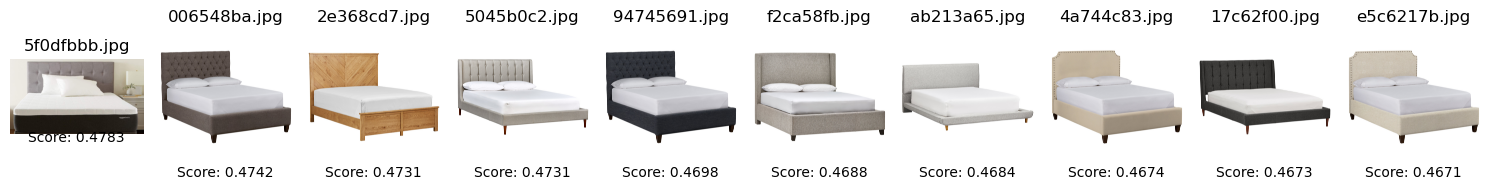

Results for test-retail-dataset-384
Query: A bed


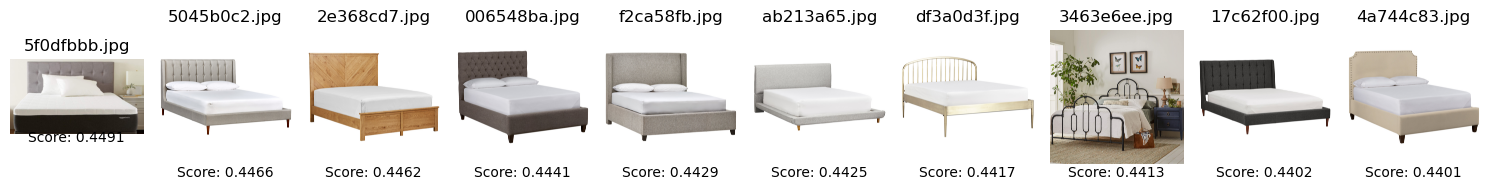

Results for test-retail-dataset-256
Query: A bed


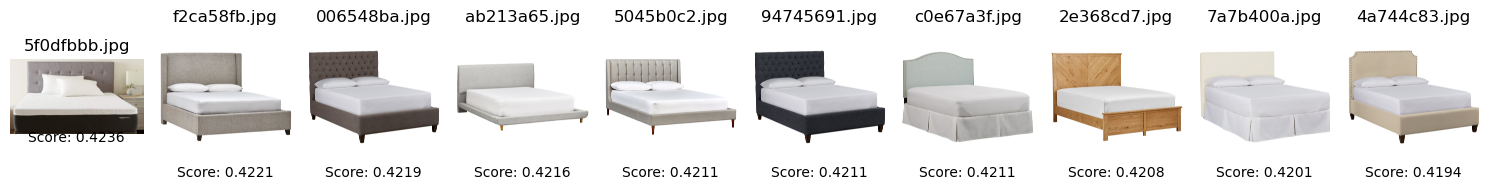

In [62]:
for result in text_query_results:
    print("Results for {}".format(result["index"]))
    print("Query: {}".format(text_query))
    display_images(result['results']["hits"]["hits"])

Results for test-retail-dataset-1024
Input: test-images/bed.png


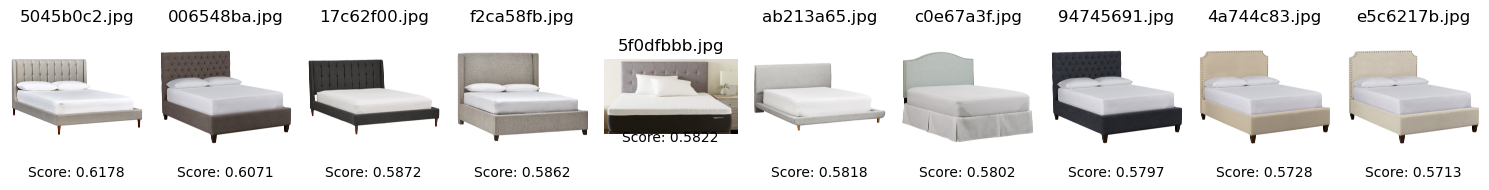

Results for test-retail-dataset-384
Input: test-images/bed.png


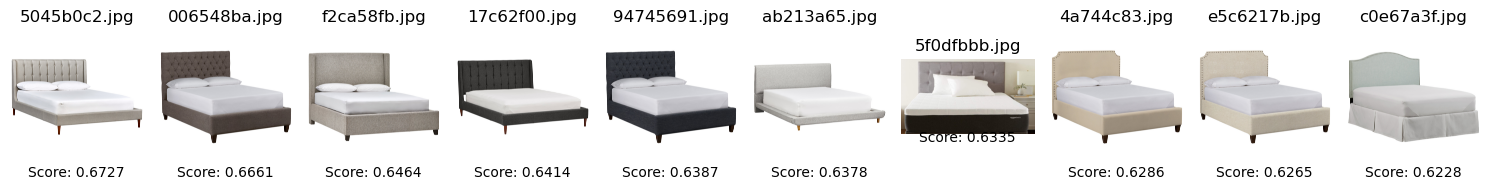

Results for test-retail-dataset-256
Input: test-images/bed.png


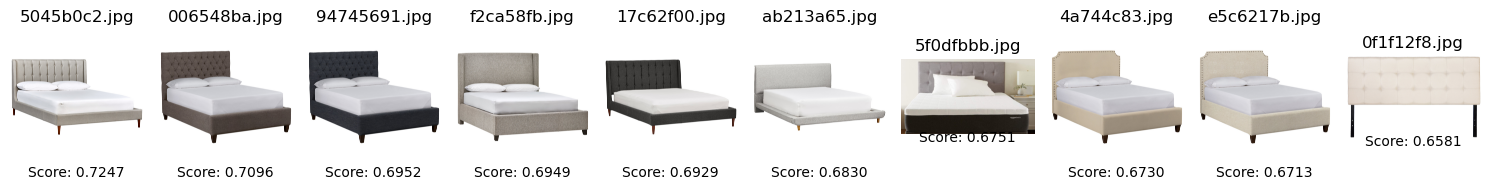

In [63]:
for result in image_query_results:
    print("Results for {}".format(result["index"]))
    print("Input: {}".format(test_image))
    display_images(result['results']["hits"]["hits"])

### Clean up 
In this section we will delete any resource which may incur in unnecessary costs.

In [8]:
response = client.delete_security_policy(
    name='{}-policy'.format(collection_name),
    type='encryption'
)

response = client.delete_security_policy(
     name='{}-policy'.format(collection_name),
    type='network'
)

response = client.delete_access_policy(
    name='{}-policy'.format(collection_name),
    type='data'
)

response = client.delete_collection(
    id=collection_id
)